<a href="https://colab.research.google.com/github/carlomagnani/Curso2020-2021-ODKG/blob/master/SP500_Trend_Forecast_1000nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print("Tensorflow version: "+tf.__version__)

#! pip install pmdarima

# Google file system
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

drive.mount('/GoogleDrive', force_remount=True)

import math

file =   "/GoogleDrive/My Drive/S&P.xlsx"
dataset = pd.read_excel(file, sheet_name="ts")

Tensorflow version: 2.8.0
Mounted at /GoogleDrive


In [3]:
dataset['log_value'] = np.log(dataset['time'])
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['log_ret'] = dataset['log_value'] - dataset['log_value'].shift(+1)
dataset['lead_ret'] = dataset['log_ret'].shift(-1)
dataset['lead_weekly_ret'] = dataset['lead_ret'].rolling(5).sum().shift(-5)
dataset['sma_3'] = dataset['log_value'].rolling(3).mean()
dataset['sma_5'] = dataset['log_value'].rolling(5).mean()
dataset['sma_10'] = dataset['log_value'].rolling(10).mean()
dataset['sma_20'] = dataset['log_value'].rolling(20).mean()
dataset['sma_50'] = dataset['log_value'].rolling(50).mean()
dataset['sma_100'] = dataset['log_value'].rolling(100).mean()
dataset['sma_200'] = dataset['log_value'].rolling(200).mean()
dataset['lead_weekly_ret_class'] = np.where(dataset['lead_weekly_ret']> 0, 1, 0)
dataset['lead_ret_class'] = np.where(dataset['lead_ret']> 0, 1, 0)


dataset['ema_200'] = dataset['log_value'].ewm(alpha = 0.01).mean()
dataset['ema_50'] = dataset['log_value'].ewm(alpha = 0.0392).mean()
dataset['ema_10'] = dataset['log_value'].ewm(alpha = 0.181).mean()
dataset['ema_3'] = dataset['log_value'].ewm(alpha = 0.5).mean()

dataset.pop('time')

dataset.dropna(inplace = True)

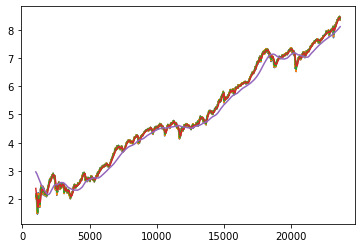

In [26]:
plt.plot(dataset['log_value'])
plt.plot(dataset['ma_3'])
plt.plot(dataset['ma_20'])
plt.plot(dataset['ma_100'])
plt.plot(dataset['ma_1000'])

In [4]:
#Signal Generation

#Momentum Rule
dataset['momentum_120'] = dataset['log_value'] - dataset['log_value'].shift(+200)
dataset['momentum_121'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+200)

dataset['mom_120_rule'] = np.where(dataset['momentum_120']> 0, 1, 0)
dataset['mom_121_rule'] = np.where(dataset['momentum_121']> 0, 1, 0)

#MA Change of Direction Rule

dataset['ma_200_cd_rule'] = np.where((dataset['sma_200']- dataset['sma_200'].shift(+1))>0,1,0)
dataset['ma_20_cd_rule'] = np.where((dataset['sma_20']- dataset['sma_20'].shift(+1))>0,1,0)

#PMA Rule

dataset['pma_20'] = dataset['log_value'] - dataset['sma_20']      
dataset['pma_100'] = dataset['log_value'] - dataset['sma_100']
dataset['pma_200'] = dataset['log_value'] - dataset['sma_200']

dataset['pma_20_rule'] = np.where(dataset['pma_20']>0, 1, 0)
dataset['pma_100_rule'] = np.where(dataset['pma_100']>0, 1, 0)
dataset['pma_200_rule'] = np.where(dataset['pma_200']>0, 1, 0)

#MA Crossover Rule

dataset['mac_3_10'] = dataset['sma_3'] - dataset['sma_10']
dataset['mac_50_200'] = dataset['sma_50'] - dataset['sma_200']

dataset['mac_3_10_rule'] = np.where(dataset['mac_3_10']>0, 1, 0)
dataset['mac_50_200_rule'] = np.where(dataset['mac_50_200']>0, 1, 0)

#Ma Convergence/Divergence Rule

dataset['mac_ema_50_200'] = dataset['ema_50'] - dataset['ema_200']

dataset['ema_mac_50_200'] = dataset['mac_ema_50_200'].ewm(alpha = 0.095).mean()

dataset['macd_50_200'] = dataset['mac_ema_50_200'] - dataset['ema_mac_50_200']

#plt.plot(dataset['macd_50_200'])

dataset['macd_50_200_rule'] = np.where(dataset['macd_50_200']>0, 1, 0)

In [5]:
rule_cols = [col for col in dataset.columns if 'rule' in col]

col_names = ['log_ret']

var_name = ['lead_weekly_ret_class']

col_names = var_name + col_names + rule_cols

#var_name = ['lead_weekly_ret_class']

print(col_names)

model_df = dataset[col_names]

model_df.dropna(inplace = True)

model_df


['lead_weekly_ret_class', 'log_ret', 'mom_120_rule', 'mom_121_rule', 'ma_200_cd_rule', 'ma_20_cd_rule', 'pma_20_rule', 'pma_100_rule', 'pma_200_rule', 'mac_3_10_rule', 'mac_50_200_rule', 'macd_50_200_rule']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,lead_weekly_ret_class,log_ret,mom_120_rule,mom_121_rule,ma_200_cd_rule,ma_20_cd_rule,pma_20_rule,pma_100_rule,pma_200_rule,mac_3_10_rule,mac_50_200_rule,macd_50_200_rule
199,1,0.003228,0,0,0,0,1,1,1,1,1,0
200,1,0.003218,0,0,1,1,1,1,1,1,1,1
201,0,0.002292,0,0,1,1,1,1,1,1,1,1
202,1,0.005479,0,0,1,1,1,1,1,1,1,1
203,0,-0.006854,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23651,0,0.014846,1,1,1,0,0,0,0,0,1,0
23652,0,0.022126,1,1,1,1,0,0,0,0,1,0
23653,0,-0.002446,1,1,1,0,0,0,0,0,1,0
23654,0,-0.015594,1,1,1,0,0,0,0,0,1,0


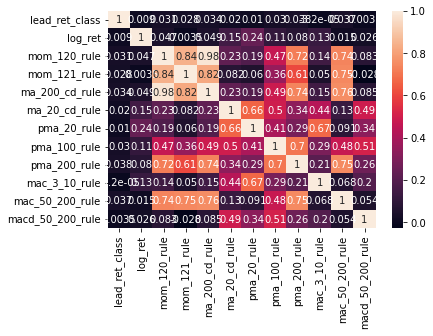

In [17]:
#Correlation Matrix

import seaborn as sn

corr_mat = model_df.corr()
sn.heatmap(corr_mat, annot=True)
plt.show()

In [6]:
#prepare Train-Test-Validate Dataset

steps = 200

values = model_df.values
n_train_hours = len(model_df) * 0.8
n_test_hours = len(model_df)*0.19

n_train_hours = round(n_train_hours)
n_test_hours = n_train_hours + round(n_test_hours)

train = values[:n_train_hours, :]
test = values[n_train_hours:n_test_hours, :]
validation = values[n_test_hours:, :]

# Creating a data structure with i time-steps and 1 output
train_X = []
train_y = []

for i in range(steps, len(train)):
    train_X.append(train[i-steps:i, 1:])
    train_y.append(train[i, 0])

train_X, train_y = np.array(train_X), np.array(train_y)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], train_X.shape[2]))

train_y = np.reshape(train_y, (train_y.shape[0],1))

In [7]:
#Test

test_X = []
test_y = []

for i in range(steps, len(test)):
  test_X.append(test[i-steps:i, 1 :])
  test_y.append(test[i, 0])

test_X, test_y = np.array(test_X), np.array(test_y)

test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], test_X.shape[2]))
test_y = np.reshape(test_y, (test_y.shape[0],1))

In [8]:
#Validate

validation_X = []
validation_y = []

for i in range(steps, len(validation)):
  validation_X.append(validation[i-steps:i, 1 :])
  validation_y.append(validation[i, 0])

validation_X, validation_y = np.array(validation_X), np.array(validation_y)

validation_X = np.reshape(validation_X, (validation_X.shape[0],validation_X.shape[1],validation_X.shape[2]))
validation_y = np.reshape(validation_y, (validation_y.shape[0],1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)


(18566, 200, 11) (18566, 1) (4257, 200, 11) (4257, 1) (34, 200, 11) (34, 1)


array([1., 1., 1., ..., 0., 0., 0.])

Epoch 1/50
581/581 - 177s - loss: 0.7333 - accuracy: 0.5268 - val_loss: 0.7038 - val_accuracy: 0.4104 - 177s/epoch - 305ms/step
Epoch 2/50
581/581 - 181s - loss: 0.7292 - accuracy: 0.5274 - val_loss: 0.6989 - val_accuracy: 0.4116 - 181s/epoch - 312ms/step
Epoch 3/50
581/581 - 182s - loss: 0.7168 - accuracy: 0.5355 - val_loss: 0.7461 - val_accuracy: 0.4104 - 182s/epoch - 314ms/step
Epoch 4/50
581/581 - 182s - loss: 0.7115 - accuracy: 0.5214 - val_loss: 0.8384 - val_accuracy: 0.4104 - 182s/epoch - 314ms/step
Epoch 5/50
581/581 - 182s - loss: 0.7119 - accuracy: 0.5256 - val_loss: 0.7375 - val_accuracy: 0.4104 - 182s/epoch - 314ms/step
Epoch 6/50
581/581 - 183s - loss: 0.7059 - accuracy: 0.5233 - val_loss: 0.7613 - val_accuracy: 0.4104 - 183s/epoch - 315ms/step
Epoch 7/50
581/581 - 183s - loss: 0.7078 - accuracy: 0.5225 - val_loss: 0.7171 - val_accuracy: 0.4104 - 183s/epoch - 315ms/step
Epoch 8/50
581/581 - 183s - loss: 0.7025 - accuracy: 0.5246 - val_loss: 0.7243 - val_accuracy: 0.4104 - 

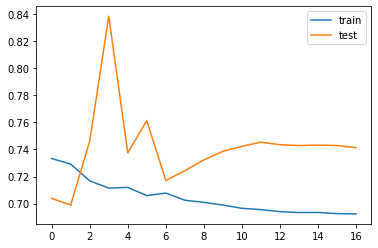

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001)

model = Sequential()

model.add(LSTM(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model.add(LSTM(1000, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(1000, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

yhat = (model.predict(validation_X) > 0.5).astype("int32")

yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])

validation_y = validation_y.reshape(validation_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(validation_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(pd.DataFrame(validation_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0], target_names = ['0', '1']))

#print(yhat, validation_y)

[[  0  91]
 [  0 123]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.57      1.00      0.73       123

    accuracy                           0.57       214
   macro avg       0.29      0.50      0.36       214
weighted avg       0.33      0.57      0.42       214



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
